In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

2025-05-28 10:52:34.056921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748429554.307919      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748429554.380265      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
r = 0.4     #scale down
width = 100 #patch size 

In [7]:
def GetData(filename):
    # read the Train and Train Dotted images
    image_1 = cv2.imread("/kaggle/input/noaa-fisheries-steller-sea-lion-population-count/KaggleNOAASeaLions/TrainDotted/" + filename)
    image_2 = cv2.imread("/kaggle/input/noaa-fisheries-steller-sea-lion-population-count/KaggleNOAASeaLions/Train/" + filename)
    

    
    img1 = cv2.GaussianBlur(image_1,(5,5),0)


    # absolute difference between Train and Train Dotted
    image_3 = cv2.absdiff(image_1,image_2)
    mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    mask_1[mask_1 < 50] = 0
    mask_1[mask_1 > 0] = 255
    image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)

    # convert to grayscale to be accepted by skimage.feature.blob_log
    image_6 = np.max(image_4,axis=2)

    # detect blobs
    blobs = skimage.feature.blob_log(image_6, min_sigma=3, max_sigma=7, num_sigma=1, threshold=0.05)

    h,w,d = image_2.shape

    res=np.zeros((int((w*r)//width)+1,int((h*r)//width)+1,5), dtype='int16')

    for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        # get the color of the pixel from Train Dotted in the center of the blob
        b,g,R = img1[int(y)][int(x)][:]
        x1 = int((x*r)//width)
        y1 = int((y*r)//width)
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        if R > 225 and b < 25 and g < 25: # RED
            res[x1,y1,0]+=1
        elif R > 225 and b > 225 and g < 25: # MAGENTA
            res[x1,y1,1]+=1
        elif R < 75 and b < 50 and 150 < g < 200: # GREEN
            res[x1,y1,4]+=1
        elif R < 75 and  150 < b < 200 and g < 75: # BLUE
            res[x1,y1,3]+=1
        elif 60 < R < 120 and b < 50 and g < 75:  # BROWN
            res[x1,y1,2]+=1

    ma = cv2.cvtColor((1*(np.sum(image_1, axis=2)>20)).astype('uint8'), cv2.COLOR_GRAY2BGR)
    img = cv2.resize(image_2 * ma, (int(w*r),int(h*r)))
    h1,w1,d = img.shape

    trainX = []
    trainY = []

    for i in range(int(w1//width)):
        for j in range(int(h1//width)):
            trainY.append(res[i,j,:])
            trainX.append(img[j*width:j*width+width,i*width:i*width+width,:])

    return np.array(trainX), np.array(trainY)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [11]:
image_dir = "/kaggle/input/noaa-fisheries-steller-sea-lion-population-count/KaggleNOAASeaLions/Train"
mismatch_path = "/kaggle/input/noaa-fisheries-steller-sea-lion-population-count/MismatchedTrainImages.txt"

# 讀取不該用的圖片檔名（每行一個檔名）
with open(mismatch_path, 'r') as f:
    bad_files = set([line.strip() for line in f])

# 過濾掉壞檔名
image_files = sorted([
    f for f in os.listdir(image_dir)
    if f.endswith(('.jpg', '.jpeg', '.png')) and f not in bad_files
])


In [14]:
import pandas as pd

image_dir = "/kaggle/input/noaa-fisheries-steller-sea-lion-population-count/KaggleNOAASeaLions/Train"
mismatch_path = "/kaggle/input/noaa-fisheries-steller-sea-lion-population-count/MismatchedTrainImages.txt"

# 讀取錯誤影像 ID，第一行是欄位名稱
df_mismatch = pd.read_csv(mismatch_path)
bad_ids = set(df_mismatch['train_id'].astype(str))  # 轉成字串以便比對檔名

# 找出所有圖片
image_files = sorted([
    f for f in os.listdir(image_dir)
    if f.endswith(('.jpg', '.jpeg', '.png'))
])

In [15]:
print(len(image_files))

948


In [16]:
filtered_files = []
for f in image_files:
    filename = os.path.splitext(f)[0]  # 取出 '3.jpg' 的 '3'
    if filename not in bad_ids:
        filtered_files.append(f)

In [17]:
print(len(filtered_files))

891


In [ ]:
trainX_list = []
trainY_list = []

cnt = 0
for file in tqdm(filtered_files, desc="Loading images"):
    X, Y = GetData(file)
    trainX_list.append(X)
    trainY_list.append(Y)
    cnt += 1
    if cnt == 50:
        break

# 合併所有圖片的資料
trainX = np.concatenate(trainX_list, axis=0)
trainY = np.concatenate(trainY_list, axis=0)

# 打亂 & 切 train/test
np.random.seed(1004)
randomize = np.arange(len(trainX))
np.random.shuffle(randomize)
trainX = trainX[randomize]
trainY = trainY[randomize]

n_train = int(len(trainX) * 0.7)
testX = trainX[n_train:]
testY = trainY[n_train:]
trainX = trainX[:n_train]
trainY = trainY[:n_train]

print("Train:", trainX.shape, trainY.shape)
print("Test:", testX.shape, testY.shape)


Loading images:   5%|▌         | 47/891 [04:03<1:14:10,  5.27s/it]

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


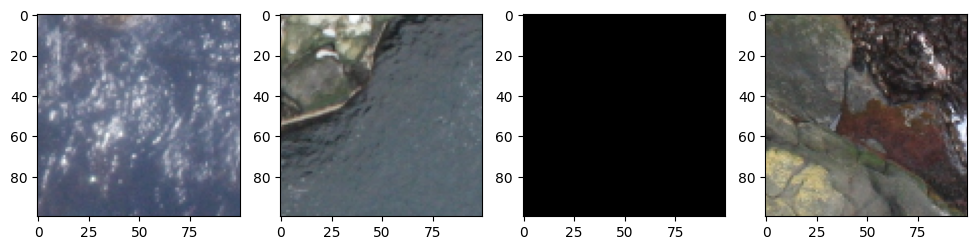

In [7]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    ax = fig.add_subplot(1,4,i+1)
    plt.imshow(cv2.cvtColor(trainX[i], cv2.COLOR_BGR2RGB))
print(trainY[:4])

In [ ]:
#%run /kaggle/input/pre-process/pre-process-whole.py

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(width,width,3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748406209.566740      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense


initial_model = applications.VGG16(weights="imagenet", include_top=False, input_shape=(100,100,3))
last = initial_model.output
x = Flatten()(last)
x = Dense(1024)(x)
x = LeakyReLU(negative_slope=0.1)(x)
preds = Dense(5, activation='linear')(x)
model = Model(initial_model.input, preds)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
print(trainX.shape)


(9840, 100, 100, 3)


In [11]:
from tensorflow import keras
from tqdm.keras import TqdmCallback

optim = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.2)
model.compile(loss='mean_squared_error', optimizer=optim)

model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    epochs=8,
    verbose=0,  # 要關掉內建的 verbose 才不會衝突
    callbacks=[TqdmCallback(verbose=1)]  # 這就是 tqdm 進度條
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

I0000 00:00:1748406224.353790     104 service.cc:148] XLA service 0x7cc5d4002d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748406224.354550     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748406224.703903     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748406231.245099     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [28]:
optim = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optim)
model.fit(
    trainX, trainY,
    validation_data=(testX, testY),  # 這行是關鍵
    epochs=30,
    verbose=2
)

Epoch 1/30
7/7 - 7s - 1s/step - loss: 1.9009 - val_loss: 1.9744
Epoch 2/30
7/7 - 1s - 77ms/step - loss: 0.7689 - val_loss: 1.1015
Epoch 3/30
7/7 - 1s - 76ms/step - loss: 0.5447 - val_loss: 0.9608
Epoch 4/30
7/7 - 1s - 76ms/step - loss: 0.3950 - val_loss: 0.8940
Epoch 5/30
7/7 - 1s - 77ms/step - loss: 0.3518 - val_loss: 0.9095
Epoch 6/30
7/7 - 1s - 76ms/step - loss: 0.2833 - val_loss: 0.9189
Epoch 7/30
7/7 - 1s - 76ms/step - loss: 0.2357 - val_loss: 0.9165
Epoch 8/30
7/7 - 1s - 76ms/step - loss: 0.1735 - val_loss: 0.9455
Epoch 9/30
7/7 - 1s - 76ms/step - loss: 0.1347 - val_loss: 0.9458
Epoch 10/30
7/7 - 1s - 76ms/step - loss: 0.1066 - val_loss: 0.9628
Epoch 11/30
7/7 - 1s - 76ms/step - loss: 0.0869 - val_loss: 0.9835
Epoch 12/30
7/7 - 1s - 76ms/step - loss: 0.0734 - val_loss: 0.9805
Epoch 13/30
7/7 - 1s - 76ms/step - loss: 0.0660 - val_loss: 0.9860
Epoch 14/30
7/7 - 1s - 76ms/step - loss: 0.0531 - val_loss: 0.9841
Epoch 15/30
7/7 - 1s - 78ms/step - loss: 0.0433 - val_loss: 1.0008
Epoch 

In [12]:
import numpy as np

result = model.predict(trainX)
print('Training set --')
print('    ground truth: ', np.sum(trainY, axis=0))
print('  evaluate count: ', np.sum(result*(result>0.3), axis=0).astype('int'))

# 先計算每張圖的真實數量跟預測數量
true_counts = np.sum(trainY, axis=1)  # axis根據你資料結構調整
pred_counts = np.sum(result * (result > 0.3), axis=1)

# 計算RMSE
rmse = np.sqrt(np.mean((true_counts - pred_counts) ** 2))
print('Training RMSE:', rmse)


result = model.predict(testX)
print('Testing set --')
print('    ground truth: ', np.sum(testY, axis=0))
print('   predict count: ', np.sum(result*(result>0.3), axis=0).astype('int'))

# 先計算每張圖的真實數量跟預測數量
true_counts = np.sum(testY, axis=1)  # axis根據你資料結構調整
pred_counts = np.sum(result * (result > 0.3), axis=1)

# 計算RMSE
rmse = np.sqrt(np.mean((true_counts - pred_counts) ** 2))
print('Testing RMSE:', rmse)

308/308 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
Training set --
    ground truth:  [ 223  222 1509  650  645]
  evaluate count:  [ 307  317 1542  714  513]
Training RMSE: 1.4172869813433837
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Testing set --
    ground truth:  [ 90  94 608 296 240]
   predict count:  [138 142 666 307 239]
Testing RMSE: 1.4486957475808417


In [13]:
print(result)

[[-3.91749199e-03 -1.21693298e-01  6.78428411e-02  1.66413099e-01
  -1.31828841e-02]
 [ 1.24525927e-01  2.01785475e-01  4.81061488e-01  5.81207573e-01
  -1.08375944e-01]
 [-3.91749199e-03 -1.21693298e-01  6.78428411e-02  1.66413099e-01
  -1.31828841e-02]
 ...
 [ 3.16288844e-02  5.24967909e-02  1.18130386e-01  1.72133788e-01
   1.41960308e-01]
 [-3.10152844e-02 -9.52079594e-02 -3.41594685e-04 -3.00089449e-01
   8.88271406e-02]
 [-1.05968378e-01 -6.10810425e-03  1.07480004e-01 -1.41637251e-01
   3.64004336e-02]]


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import time
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm
import tensorflow as tf

# === 參數設定 ===
patch_size = 100
batch_image_count = 16  # 一次處理幾張圖（可自行調整）
test_dir = '/kaggle/input/noaa-fisheries-steller-sea-lion-population-count/KaggleNOAASeaLions/Test'
test_files = sorted([f for f in os.listdir(test_dir) if f.endswith('.jpg')])
results = []

# === 開始整體計時 ===
total_start_time = time.time()

print("✅ 是否可用 GPU:", tf.config.list_physical_devices('GPU'))

def extract_patches_from_image(image, patch_size=100):
    h, w, _ = image.shape
    patches = []
    coords = []

    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]
            # padding
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                padded = np.zeros((patch_size, patch_size, 3), dtype=np.uint8)
                padded[:patch.shape[0], :patch.shape[1], :] = patch
                patch = padded
            patches.append(patch)
            coords.append((x, y))
    return patches, coords

# 模型使用 GPU 設備推論
with tf.device('/GPU:0'):
    for i in tqdm(range(0, len(test_files), batch_image_count), desc="Batch Predicting"):
        batch_files = test_files[i:i+batch_image_count]
        all_patches = []
        image_patch_counts = []  # 用來還原每張圖有幾個 patch
        batch_images = []

        # Step 1: 提取所有 patch
        for file in batch_files:
            img_path = os.path.join(test_dir, file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"讀不到圖片：{file}")
                continue
            scale = 0.4
            new_w = int(img.shape[1] * scale)
            new_h = int(img.shape[0] * scale)
            img = cv2.resize(img, (new_w, new_h))
            patches, _ = extract_patches_from_image(img, patch_size)
            batch_images.append((file, len(patches)))
            image_patch_counts.append(len(patches))
            for patch in patches:
                patch_array = img_to_array(patch) / 255.0
                all_patches.append(patch_array)

        if len(all_patches) == 0:
            continue

        # Step 2: 預測所有 patch（mega batch）
        batch_array = np.array(all_patches)
        start_time = time.time()
        preds = model.predict(batch_array, verbose=0)
        elapsed = time.time() - start_time

        # Step 3: 將 patch 預測合併為每張圖的總預測
        idx = 0
        for (file, patch_count) in batch_images:
            pred_sum = np.sum(preds[idx:idx+patch_count], axis=0)
            pred_sum = np.round(pred_sum).astype(int)
            test_id = int(file.split('.')[0])
            results.append([test_id] + pred_sum.tolist())  # 平均每張圖的時間
            idx += patch_count

# === 儲存結果 ===
df = pd.DataFrame(results, columns=[
    'test_id',
    'adult_males',
    'subadult_males',
    'adult_females',
    'juveniles',
    'pups',
])
df.sort_values(by='test_id', inplace=True)
df.to_csv('submission_batch_patch_based.csv', index=False)

total_time = time.time() - total_start_time
print(f"\n✅ 預測完成！總耗時 {total_time:.2f} 秒")
print("📁 儲存為 submission_batch_patch_based.csv")


✅ 是否可用 GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


🔍 Batch Predicting:  20%|█▉        | 230/1165 [37:09<2:30:39,  9.67s/it]

In [15]:
results_trimmed = [r[:6] for r in results]

processed_results = [
    [row[0]] + [max(0, x) for x in row[1:]]
    for row in results_trimmed
]

df = pd.DataFrame(processed_results, columns=[
    'test_id',
    'adult_males',
    'subadult_males',
    'adult_females',
    'juveniles',
    'pups'
])

print((df.iloc[:, 1:] < 0).any().any())  # 應該要是 False

df.sort_values(by='test_id', inplace=True)
df.to_csv('submission_batch_patch_based.csv', index=False)

total_time = time.time() - total_start_time
print(f"\n✅ 預測完成！總耗時 {total_time:.2f} 秒")
print("📁 儲存為 submission_batch_patch_based.csv")

False

✅ 預測完成！總耗時 56.36 秒
📁 儲存為 submission_batch_patch_based.csv
